RAIN - Real & Artificial Intelligence for Neuroscience

## Geometric analysis
- This notebook will take the position.csv files (created using 1-Prepare_positions.ipynb) and process them using geometric criteria (distance, angle and overall movement)

#### Requirements:
- The position.csv files
- Geometric thresholds for exploration and freezing (see below)

---
#### Load the necessary modules

In [21]:
import os
from glob import glob
import rainstorm.geometric_analysis as rst

---
#### 1. State your project path & thresholds
All we need to define is the path to the folder where the data is stored, and the path to the parameters file (which contains the thresholds for the geometric analysis).

In [22]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
# folder_path = os.path.join(base, r'docs\examples\NOR_example')
folder_path = r'C:\Users\dhers\Desktop\Rainstorm\docs\examples\SP_6mth'
params = os.path.join(folder_path, 'params.yaml')

---
#### 2. We can open an example file and see what is inside

In [23]:
# Choose an example file to plot:
all_position = glob(os.path.join(folder_path,"*/position/*position.csv"))
example_path = rst.choose_example(all_position, look_for = 'TR1')

Plotting coordinates from 2025_02-R15-Social_TR1_position.csv


In [24]:
# Plot mouse exploration around multiple objects
rst.plot_position(params, example_path)

On the plot we have the position of each object in the example file. We can see the nose tracked and colored according to the angle of approach towards the objects.

We label exploration events when the nose is colored (heading towards the object) and inside the dashed line (close to the object).

In [25]:
import yaml
import pandas as pd
import numpy as np

def load_yaml(file_path):
    """Load YAML file and return the data."""
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

def is_point_in_rotated_rectangle(x, y, center, width, height, angle):
    """Check if a point (x, y) is inside a rotated rectangle."""
    angle = np.radians(angle)
    cos_a, sin_a = np.cos(angle), np.sin(angle)

    # Translate point relative to the rectangle center
    x_rel, y_rel = x - center[0], y - center[1]

    # Rotate the point in the opposite direction
    x_rot = x_rel * cos_a + y_rel * sin_a
    y_rot = -x_rel * sin_a + y_rel * cos_a

    # Check if the point falls within the unrotated rectangle's bounds
    return (-width / 2 <= x_rot <= width / 2) and (-height / 2 <= y_rot <= height / 2)

def assign_bodypart_areas(params_path, file, bodyparts = ['body']):
    """Assigns an area to each body part for each frame."""
    # Load parameters
    params = load_yaml(params_path)
    roi_data = params.get("roi_data", {})
    areas = roi_data.get("areas", [])

    # Read the .csv
    df = pd.read_csv(file)

    # Create a new DataFrame for results
    roi_activity = pd.DataFrame(index=df.index)

    for bp in bodyparts:
        area_col = []
        for i, row in df.iterrows():
            x, y = row[f"{bp}_x"], row[f"{bp}_y"]
            assigned_area = None
            for area in areas:
                if is_point_in_rotated_rectangle(x, y, area["center"], area["width"], area["height"], area["angle"]):
                    assigned_area = area["name"]
                    break
            area_col.append(assigned_area)
        
        roi_activity[bp] = area_col  # Assign the area to the corresponding body part column
    
    return roi_activity

In [26]:
roi_activity = assign_bodypart_areas(params, example_path)
print(roi_activity)

             body
0          center
1          center
2          center
3          center
4          center
...           ...
8995  red_chamber
8996  red_chamber
8997  red_chamber
8998  red_chamber
8999  red_chamber

[9000 rows x 1 columns]


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_bodypart_heatmap(params_path, file, bodypart = 'body', bins=50, cmap="Reds", alpha=0.6):
    """
    Plots a heatmap of body part positions overlaid with ROIs.

    Parameters:
    - df: DataFrame containing body part positions.
    - bodypart: The body part to analyze (e.g., "nose").
    - roi_data: Dictionary containing ROI information from params.yaml.
    - bins: Number of bins for the heatmap (default: 50).
    - cmap: Colormap for the heatmap (default: "Reds").
    - alpha: Transparency level for the heatmap (default: 0.6).
    """

    # Load parameters
    params = load_yaml(params_path)
    roi_data = params.get("roi_data", {})
    areas = roi_data.get("areas", [])
    frame_width = roi_data["frame_shape"]["width"]
    frame_height = roi_data["frame_shape"]["height"]

    # Read the .csv
    df = pd.read_csv(file)

    # Extract x and y positions of the body part
    x_vals = df[f"{bodypart}_x"].dropna().values
    y_vals = df[f"{bodypart}_y"].dropna().values

    # Create a 2D histogram (heatmap)
    heatmap, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=bins, 
                                             range=[[0, frame_width], [0, frame_height]])

    # Transpose the heatmap for correct orientation
    heatmap = heatmap.T

    # Create figure
    fig, ax = plt.subplots(figsize=(frame_width / 100, frame_height / 100))  # Scale size
    ax.set_xlim(0, frame_width)
    ax.set_ylim(0, frame_height)
    ax.invert_yaxis()  # Invert Y-axis to match video coordinates
    ax.set_title(f"Heatmap of {bodypart} positions")

    # Plot heatmap
    ax.imshow(heatmap, extent=[0, frame_width, 0, frame_height], origin="lower", cmap=cmap, alpha=alpha)

    # Plot ROIs
    for area in areas:
        center_x, center_y = area["center"]
        width, height = area["width"], area["height"]
        angle = area["angle"]

        # Create rotated rectangle
        rect = patches.Rectangle(
            (center_x - width / 2, center_y - height / 2), width, height,
            angle=angle, rotation_point="center", edgecolor="blue", facecolor="none", lw=2
        )
        ax.add_patch(rect)
        ax.text(center_x, center_y, area["name"], fontsize=10, color="blue", 
                ha="center", va="center", bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    plt.show()


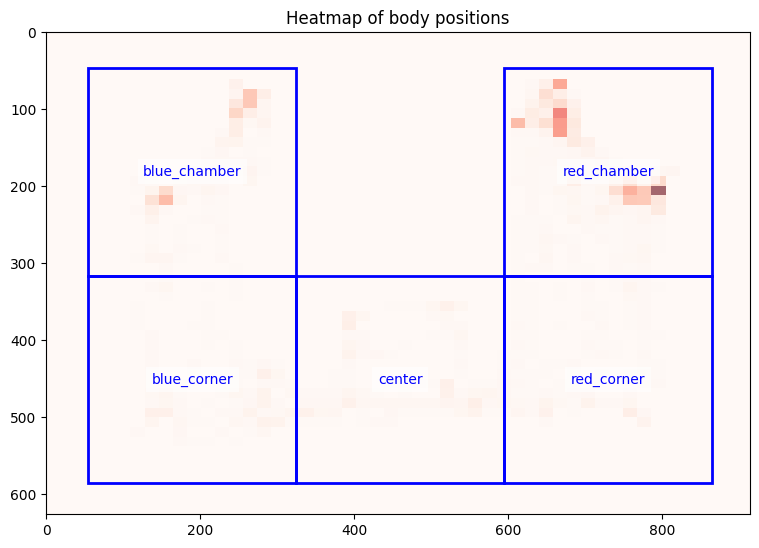

In [28]:
# Example usage:
plot_bodypart_heatmap(params, example_path)

In [29]:
def plot_time_spent(area_df, bodypart = 'body', fps=30):
    """
    Plots the time spent in each area for a specific body part.
    
    Parameters:
    - area_df: DataFrame containing the assigned areas for each body part.
    - bodypart: The body part to analyze (column name).
    - fps: Frames per second of the video (default: 30).
    """
    # Count occurrences of each area
    time_spent = area_df[bodypart].value_counts().sort_index()

    # Convert frame count to time (seconds)
    time_spent_seconds = time_spent / fps

    # Plot
    plt.figure(figsize=(8, 5))
    time_spent_seconds.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("Area")
    plt.ylabel("Time spent (s)")
    plt.title(f"Time spent in each area - {bodypart}")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

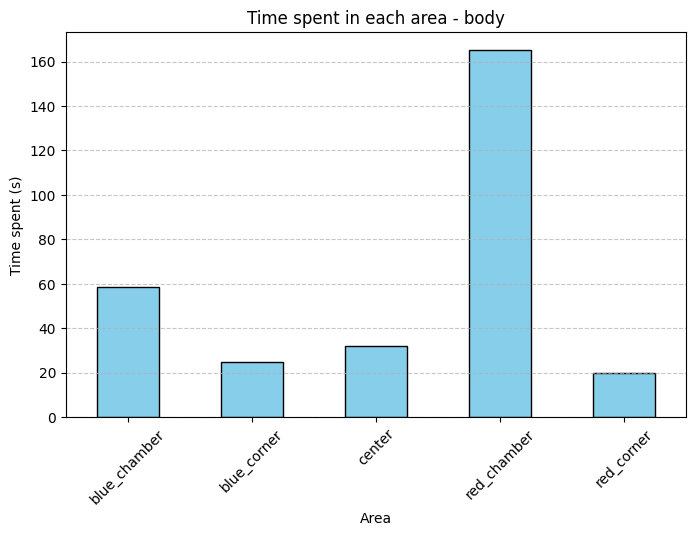

In [30]:
# Example usage:
plot_time_spent(roi_activity)

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_bodypart_positions(params_path, file, area_df, bodypart="body"):
    """
    Plots individual body part positions, colored according to their assigned area.

    Parameters:
    - params_path: Path to the YAML file with ROI information.
    - df: DataFrame containing body part positions.
    - area_df: DataFrame containing area classifications for each body part.
    - bodypart: The body part to analyze (default: "body").
    """
    params = load_yaml(params_path)
    roi_data = params.get("roi_data", {})
    frame_shape = roi_data.get("frame_shape", {})
    areas = roi_data.get("areas", [])

    frame_width = frame_shape["width"]
    frame_height = frame_shape["height"]

    # Read the .csv
    df = pd.read_csv(file)
    
    # Extract x and y positions
    x_vals = df[f"{bodypart}_x"].values
    y_vals = df[f"{bodypart}_y"].values
    labels = area_df[bodypart].values  # Assigned area labels

    # Define a color map for the different areas
    unique_areas = [area["name"] for area in areas] + ["Outside"]
    colors = plt.cm.get_cmap("tab10", len(unique_areas))  # Different colors per area
    area_colors = {area: colors(i) for i, area in enumerate(unique_areas)}

    # Create figure
    fig, ax = plt.subplots(figsize=(frame_width / 100, frame_height / 100))  
    ax.set_xlim(0, frame_width)
    ax.set_ylim(0, frame_height)
    ax.invert_yaxis()  # Match video coordinates
    ax.set_title(f"Scatter plot of {bodypart} positions")

    # Scatter plot with colors based on assigned area
    for area_name in unique_areas:
        mask = labels == area_name
        ax.scatter(x_vals[mask], y_vals[mask], label=area_name, color=area_colors[area_name], alpha=0.6, s=10)

    # Plot ROIs
    for area in areas:
        center_x, center_y = area["center"]
        width, height = area["width"], area["height"]
        angle = area["angle"]

        # Create rotated rectangle
        rect = patches.Rectangle(
            (center_x - width / 2, center_y - height / 2), width, height,
            angle=angle, rotation_point="center", edgecolor="black", facecolor="none", lw=2
        )
        ax.add_patch(rect)
        ax.text(center_x, center_y, area["name"], fontsize=10, color="black",
                ha="center", va="center", bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    ax.legend(title="Assigned Area")
    plt.show()


C:\Users\dhers\AppData\Local\Temp\ipykernel_14500\2386400214.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



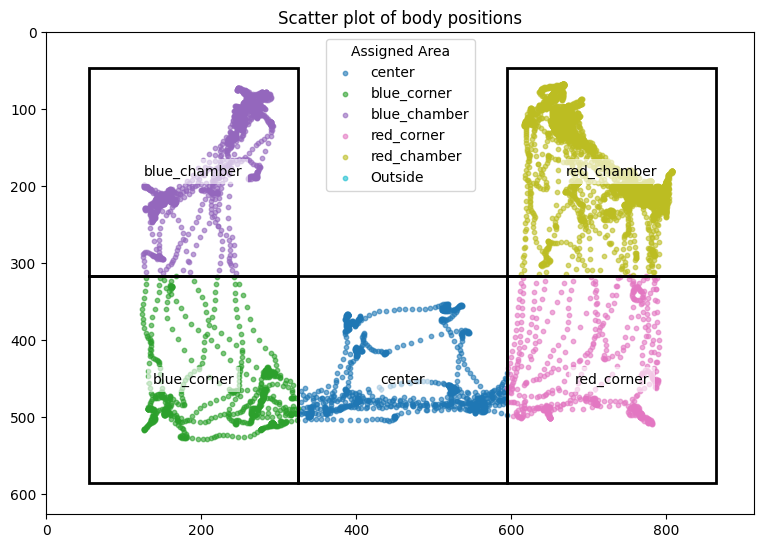

In [32]:
plot_bodypart_positions(params, example_path, roi_activity)

---
#### 3.  We can also measure other behaviours, such as freezing

In [33]:
# Plot freezing events
rst.plot_freezing(params, example_path)

Now we are plotting the movement of the mouse. by setting a threshold (we can modify it above) we can quantify the time the mouse spent freezing.

---
#### 4. Finally, we can analyze the position files and create:
- A movement.csv file containing distance traveled, freezing and darting.
- A geolabels.csv file with the exploration of each object, frame by frame.

In [6]:
# Analyze all files in the folder
rst.create_movement_and_geolabels(params)

Saved geolabels to 2025_02-R01-Social_Hab_geolabels.csv
Saved movement to 2025_02-R01-Social_Hab_movement.csv
Saved geolabels to 2025_02-R02-Social_Hab_geolabels.csv
Saved movement to 2025_02-R02-Social_Hab_movement.csv
Saved geolabels to 2025_02-R03-Social_Hab_geolabels.csv
Saved movement to 2025_02-R03-Social_Hab_movement.csv
Saved geolabels to 2025_02-R04-Social_Hab_geolabels.csv
Saved movement to 2025_02-R04-Social_Hab_movement.csv
Saved geolabels to 2025_02-R05-Social_Hab_geolabels.csv
Saved movement to 2025_02-R05-Social_Hab_movement.csv
Saved geolabels to 2025_02-R06-Social_Hab_geolabels.csv
Saved movement to 2025_02-R06-Social_Hab_movement.csv
Saved geolabels to 2025_02-R07-Social_Hab_geolabels.csv
Saved movement to 2025_02-R07-Social_Hab_movement.csv
Saved geolabels to 2025_02-R08-Social_Hab_geolabels.csv
Saved movement to 2025_02-R08-Social_Hab_movement.csv
Saved geolabels to 2025_02-R09-Social_Hab_geolabels.csv
Saved movement to 2025_02-R09-Social_Hab_movement.csv
Saved geol

---
---
#### Two new csv files were created for each video, one for geolabels and the other for movement related scores.
We can:
- Move on to the next notebook to create an artificial neural network that labels exploratory behavior, 3-Create_models.ipynb
- Loose all patience, go straight to 7-Seize_labels.ipynb and use the geolabels to plot the results of the experiment

---
RAINSTORM - Created on Oct 26, 2023 - @author: Santiago D'hers